In [1]:
# imports
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set()
import sklearn
from __future__ import print_function
from IPython.display import Image
from IPython.display import display
from IPython.display import HTML
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import preprocessing
#import tabletext
#from tabletext import to_text

C:\Users\Sri\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Load data from disk and preview data
dt1 = pd.read_csv("C:/Users/Sri/Desktop/911_project/DATASET/911_nan_zip_dataset.csv")
dt1.head(3)

,lat,lng,zip,Category,Title,timeStamp,twp
0,40.297876,-75.581294,19525.0,EMS,BACK PAINS/INJURY,2015-12-10 17:40,NEW HANOVER
1,40.258061,-75.264680,19446.0,EMS,DIABETIC EMERGENCY,2015-12-10 17:40,HATFIELD TOWNSHIP
2,40.121182,-75.351975,19401.0,Fire,GAS-ODOR/LEAK,2015-12-10 17:40,NORRISTOWN



If description and address exsists then drop them by below coomnds :
dt2 = dt1.drop(["Description","Address"],axis=1)

In [3]:
dt2 = dt1

In [4]:
dt2.head()

,lat,lng,zip,Category,Title,timeStamp,twp
0,40.297876,-75.581294,19525.0,EMS,BACK PAINS/INJURY,2015-12-10 17:40,NEW HANOVER
1,40.258061,-75.264680,19446.0,EMS,DIABETIC EMERGENCY,2015-12-10 17:40,HATFIELD TOWNSHIP
2,40.121182,-75.351975,19401.0,Fire,GAS-ODOR/LEAK,2015-12-10 17:40,NORRISTOWN
3,40.116153,-75.343513,19401.0,EMS,CARDIAC EMERGENCY,2015-12-10 17:40,NORRISTOWN
4,40.251492,-75.603350,19464.0,EMS,DIZZINESS,2015-12-10 17:40,LOWER POTTSGROVE


In [5]:

# check if we have rows with empty data in the dataset
print ("lat empty count :", dt2['lat'].isnull().sum())
print ("lng empty count :", dt2['lng'].isnull().sum())
print ("zip empty count :", dt2['zip'].isnull().sum())
print ("title empty count :", dt2['Title'].isnull().sum())
print ("timeStamp empty count :", dt2['timeStamp'].isnull().sum())
print ("twp empty count :", dt2['twp'].isnull().sum())

lat empty count : 0
lng empty count : 0
zip empty count : 228
title empty count : 0
timeStamp empty count : 0
twp empty count : 43


# cleaning columns with empty values, we can achieve our goals without them 
# it is better to remove columns than get rid of around 18k of events
dt3 = dt2.drop(["zip","twp"],axis=1)
dt3.head(3)

In [6]:
dt2.describe()

,lat,lng,zip
count,99492.000000,99492.000000,99264.000000
mean,40.159526,-75.317464,19240.355325
std,0.094446,0.174826,334.470500
min,30.333596,-95.595595,17752.000000
25%,40.100423,-75.392104,19038.000000
50%,40.145223,-75.304667,19401.000000
75%,40.229008,-75.212513,19446.000000
max,41.167156,-74.995041,77316.000000


In [7]:
# it seems we have some outliers in the geographical data. 
# Montgomery County (PA) does not have any locations with min lat 30.333596 or min lng -95.595595. 
# there must be some human (data entry operator) mistakes and we need to identify them
outliers = dt2.loc[((dt2['lat'] < 39.00) | (dt2['lat'] > 41.00)) & 
                   ((dt2['lng'] < -77.00) | (dt2['lng'] > -74.00))]
print ("Outliers :\n",outliers)

Outliers :
              lat        lng      zip Category                Title  \
25715  32.387090 -86.276106  36107.0  Traffic   DISABLED VEHICLE -   
67109  30.333596 -95.595595  77316.0      EMS    CARDIAC EMERGENCY   

              timeStamp         twp  
25715  2016-02-12 18:47  MONTGOMERY  
67109  2016-06-02 13:36  MONTGOMERY  


In [8]:
# we have just a few outliers, removing them will not affect the result. Lets filter out the outliers
dt3 = dt2.loc[((dt2['lat'] > 39.00) & (dt2['lat'] < 41.00)) & 
              ((dt2['lng'] > -77.00) & (dt2['lng'] < -74.00))]
# and describe the dataset again to check effect of the cleaning
dt3.describe()

,lat,lng,zip
count,99477.000000,99477.000000,99249.000000
mean,40.159701,-75.316713,19239.589185
std,0.085615,0.151597,273.873084
min,39.956497,-75.729789,18036.000000
25%,40.100423,-75.392104,19038.000000
50%,40.145223,-75.304642,19401.000000
75%,40.229008,-75.212439,19446.000000
max,40.584929,-74.995041,19525.000000


In [9]:
# we want to get event type from its title
# first we list unique values in title
titles_unique = pd.DataFrame(dt3.Title.unique())
titles_unique = titles_unique.sort_values([0],ascending =  True)
print ("Unique titles size :",len(titles_unique))
titles_unique.head(5)

Unique titles size : 81


,0
27,ABDOMINAL PAINS
74,ACTIVE SHOOTER
42,ALLERGIC REACTION
17,ALTERED MENTAL STATUS
66,AMPUTATION


In [10]:
dt4 = dt3

In [11]:
dt4.head()

,lat,lng,zip,Category,Title,timeStamp,twp
0,40.297876,-75.581294,19525.0,EMS,BACK PAINS/INJURY,2015-12-10 17:40,NEW HANOVER
1,40.258061,-75.264680,19446.0,EMS,DIABETIC EMERGENCY,2015-12-10 17:40,HATFIELD TOWNSHIP
2,40.121182,-75.351975,19401.0,Fire,GAS-ODOR/LEAK,2015-12-10 17:40,NORRISTOWN
3,40.116153,-75.343513,19401.0,EMS,CARDIAC EMERGENCY,2015-12-10 17:40,NORRISTOWN
4,40.251492,-75.603350,19464.0,EMS,DIZZINESS,2015-12-10 17:40,LOWER POTTSGROVE


If this dataset happens to have a category not classified then split the column

dt5 = dt3.copy()
dt5['category'],dt5['category2'] = dt5['Title'].str.split(':',1).str
dt5 = dt5.drop(['Title','category2'],axis = 1)
cat_unique = pd.DataFrame(dt5.category.unique())
cat_unique = cat_unique.sort_values([0],ascending =  True)
cat_unique.head()

In [12]:
# We now have the dictionary of the unique categories. We can change strings in dataset to the category numbers. 
# That is necessary as we want to feed the Machine Learning model with this dataset
# and it must contain only numeric values. Here is the mapping:
# 0 = EMS (Emergency Medical Services)
# 1 = FIRE
# 2 =  TRAFFIC
CATEGORIES = {'EMS':0,'Fire':1,'Traffic':2}
dt4['Category'].replace(CATEGORIES,inplace=True)
dt4.head(3)

C:\Users\Sri\Anaconda3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,lat,lng,zip,Category,Title,timeStamp,twp
0,40.297876,-75.581294,19525.0,0,BACK PAINS/INJURY,2015-12-10 17:40,NEW HANOVER
1,40.258061,-75.264680,19446.0,0,DIABETIC EMERGENCY,2015-12-10 17:40,HATFIELD TOWNSHIP
2,40.121182,-75.351975,19401.0,1,GAS-ODOR/LEAK,2015-12-10 17:40,NORRISTOWN


In [13]:
# now we want to parse timestamp to get more information from it.
# we will extend the dataset with more time related values
# hours_range allows us to split day into several periods, each hours_range long
hours_range = 8
dt6 = dt4
dt6['datetime'] = pd.to_datetime(dt4['timeStamp'])
dt6['year'] = dt4['datetime'].dt.year
dt6['month'] = dt4['datetime'].dt.month
dt6['day'] = dt4['datetime'].dt.day
dt6['day_part'] = np.floor(dt4['datetime'].dt.hour/hours_range)
dt6['day_part'] = dt4.day_part.astype(int)
dt6['dayofweek'] = dt4['datetime'].dt.dayofweek
dt6['week'] = dt4['datetime'].dt.week
#let's describe the dat again
dt6.describe()

C:\Users\Sri\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Sri\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Sri\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

,lat,lng,zip,Category,year,month,day,day_part,dayofweek,week
count,99477.000000,99477.000000,99249.000000,99477.000000,99477.000000,99477.000000,99477.000000,99477.000000,99477.000000,99477.000000
mean,40.159701,-75.316713,19239.589185,0.867396,2015.919901,4.983383,15.931944,1.214442,2.886255,20.125949
std,0.085615,0.151597,273.873084,0.912393,0.271448,3.012122,8.580983,0.705068,1.963917,13.614837
min,39.956497,-75.729789,18036.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,40.100423,-75.392104,19038.000000,0.000000,2016.000000,3.000000,9.000000,1.000000,1.000000,9.000000
50%,40.145223,-75.304642,19401.000000,1.000000,2016.000000,5.000000,16.000000,1.000000,3.000000,19.000000
75%,40.229008,-75.212439,19446.000000,2.000000,2016.000000,7.000000,23.000000,2.000000,5.000000,28.000000
max,40.584929,-74.995041,19525.000000,2.000000,2016.000000,12.000000,31.000000,2.000000,6.000000,53.000000


In [14]:
dt6.head(2)

,lat,lng,zip,Category,Title,timeStamp,twp,datetime,year,month,day,day_part,dayofweek,week
0,40.297876,-75.581294,19525.0,0,BACK PAINS/INJURY,2015-12-10 17:40,NEW HANOVER,2015-12-10 17:40:00,2015,12,10,2,3,50
1,40.258061,-75.264680,19446.0,0,DIABETIC EMERGENCY,2015-12-10 17:40,HATFIELD TOWNSHIP,2015-12-10 17:40:00,2015,12,10,2,3,50



# the geo coordinates have limited range
# we want to split the whole location into the geo grid
# epsilon is to extend the upper bound minimally 
# to avoid assigning locations at the end of the range to new slot beyond the grid
epsilon = 0.0001
lat_max = dt6['lat'].max() + epsilon
lat_min = dt6['lat'].min()
lat_range = lat_max - lat_min
print ("Latitude min-max: <",lat_min,lat_max,"> | range :",lat_range)
lng_max = dt6['lng'].max() + epsilon
lng_min = dt6['lng'].min()
lng_range = lng_max - lng_min
print ("Longitude min-max: <",lng_min,lng_max,"> | range :",lng_range)

In [15]:
epsilon = 0.0001
lat_max = dt6['lat'].max() + epsilon
lat_min = dt6['lat'].min()
lat_range = lat_max - lat_min
print ("Latitude min-max: <",lat_min,lat_max,"> | range :",lat_range)
lng_max = dt6['lng'].max() + epsilon
lng_min = dt6['lng'].min()
lng_range = lng_max - lng_min
print ("Longitude min-max: <",lng_min,lng_max,"> | range :",lng_range)

Latitude min-max: < 39.9564971 40.585029299999995 > | range : 0.6285321999999951
Longitude min-max: < -75.7297893 -74.9949414 > | range : 0.7348478999999912


# Let's then split the area set by these coordinates into an grid
# we will divide the lat and lng range, thus creating grid of rectangles
lat_split = 5 # number of horizontal parts
lng_split = 7 # number of vertical parts
lat_hop = lat_range/lat_split # lat divided to N parts gives us length of one part
print ("Lat hop : ",lat_hop)
lng_hop = lng_range/lng_split # lng divided to N parts gives us length of one part
print ("Lng hop : ",lng_hop)
# now we need to assign coordinates to proper geogrid squares
dt6['lat_grid'] = (np.floor(((dt6['lat']-lat_min)/lat_hop)))
dt6['lng_grid'] = (np.floor(((dt6['lng']-lng_min)/lng_hop)))
dt6.lat_grid = dt6.lat_grid.astype(int)
dt6.lng_grid = dt6.lng_grid.astype(int)
dt7 = dt6.drop(['lat','lng'],axis = 1)
dt7 = dt6
dt7.head(3)

In [16]:
# Let's then split the area set by these coordinates into an grid
# we will divide the lat and lng range, thus creating grid of rectangles
lat_split = 5 # number of horizontal parts
lng_split = 7 # number of vertical parts
lat_hop = lat_range/lat_split # lat divided to N parts gives us length of one part
print ("Lat hop : ",lat_hop)
lng_hop = lng_range/lng_split # lng divided to N parts gives us length of one part
print ("Lng hop : ",lng_hop)
# now we need to assign coordinates to proper geogrid squares
dt6['lat_grid'] = (np.floor(((dt6['lat']-lat_min)/lat_hop)))
dt6['lng_grid'] = (np.floor(((dt6['lng']-lng_min)/lng_hop)))
dt6.lat_grid = dt6.lat_grid.astype(int)
dt6.lng_grid = dt6.lng_grid.astype(int)
dt7 = dt6.drop(['lat','lng'],axis = 1)
dt7 = dt6
dt7.head(3)

Lat hop :  0.12570643999999903
Lng hop :  0.10497827142857018


C:\Users\Sri\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Sri\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Sri\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,lat,lng,zip,Category,Title,timeStamp,twp,datetime,year,month,day,day_part,dayofweek,week,lat_grid,lng_grid
0,40.297876,-75.581294,19525.0,0,BACK PAINS/INJURY,2015-12-10 17:40,NEW HANOVER,2015-12-10 17:40:00,2015,12,10,2,3,50,2,1
1,40.258061,-75.264680,19446.0,0,DIABETIC EMERGENCY,2015-12-10 17:40,HATFIELD TOWNSHIP,2015-12-10 17:40:00,2015,12,10,2,3,50,2,4
2,40.121182,-75.351975,19401.0,1,GAS-ODOR/LEAK,2015-12-10 17:40,NORRISTOWN,2015-12-10 17:40:00,2015,12,10,2,3,50,1,3


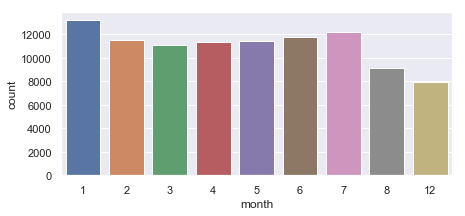

In [17]:

# let's check number of events per month
fig, ax = plt.subplots(figsize=(7,3))  
ax = sns.countplot(x="month", data=dt7,ax=ax)

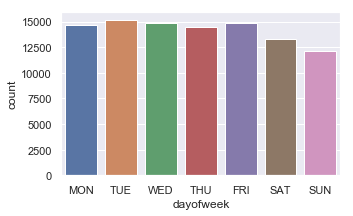

In [18]:

# let's check number of events per day of the week
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.countplot(x="dayofweek", data=dt7)
ax.axes.set_xticklabels(["MON", "TUE","WED","THU","FRI","SAT","SUN"])
pass

[Text(0,0,'EMS'), Text(0,0,'FIRE'), Text(0,0,'TRAFFIC')]

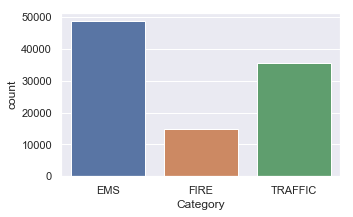

In [19]:
#let's see the size of each category (class)
# 0 = EMS (Emergency Medical Services), 1 = FIRE, 2 =  TRAFFIC
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.countplot(x="Category", data=dt7)
ax.axes.set_xticklabels(["EMS","FIRE","TRAFFIC"])


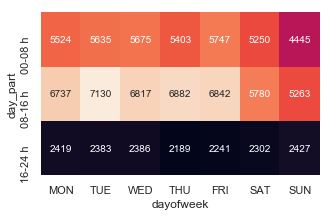

In [20]:
# lets check the time impact on the events
dt_timegrid = dt7.groupby(['dayofweek','day_part']).size().reset_index(name='count')
dt_timeheatmap = dt_timegrid.pivot(index='day_part', columns='dayofweek', values='count')
# generate heatmap
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.heatmap(dt_timeheatmap,annot=True, fmt="d",cbar=False)
ax.invert_yaxis()
ax.axes.set_yticklabels(["16-24 h","08-16 h","00-08 h"])
ax.axes.set_xticklabels(["MON", "TUE","WED","THU","FRI","SAT","SUN"])
pass

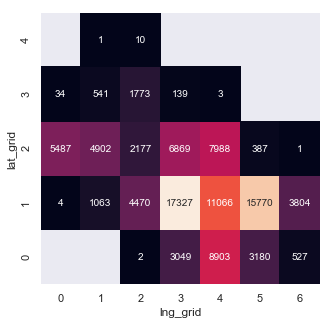

Longitude min-max: < -75.7297893 -74.9949414 > | range : 0.7348478999999912
Latitude min-max: < 39.9564971 40.585029299999995 > | range : 0.6285321999999951


In [21]:
# now we can visualize our data on the geogrid.
dt_geogrid = dt7.groupby(['lat_grid','lng_grid']).size().reset_index(name='count')
dt_geoheatmap = dt_geogrid.pivot(index='lat_grid',columns='lng_grid', values='count')
# generate heatmap
fig, ax = plt.subplots(figsize=(5,5))  
ax = sns.heatmap(dt_geoheatmap,annot=True,fmt=".0f",cbar=False)
ax.invert_yaxis()
plt.show()
print ("Longitude min-max: <",lng_min,lng_max,"> | range :",lng_range)
print ("Latitude min-max: <",lat_min,lat_max,"> | range :",lat_range)
#draw reference map
#print ("\nUS PA Montgomery County Reference map") 
#print ("Map source: OpenStreetMap.org, Map license: Open Data Commons Open Database License (ODbL).")
#img = Image(filename = "montco-map-grid.png", width=480, height=480)
#display(img)
# save plots locally

In [22]:

# reorganize table to have mor intuitive order of the features
final_columns = ["month","week","dayofweek","day","day_part","lat_grid","lng_grid","Category"]
dt7 = dt6[final_columns]
dt7.head(3)

,month,week,dayofweek,day,day_part,lat_grid,lng_grid,Category
0,12,50,3,10,2,2,1,0
1,12,50,3,10,2,2,4,0
2,12,50,3,10,2,1,3,1


In [23]:
dt7.to_csv('C:/Users/Sri/Desktop/911_project/act.csv')

In [24]:
# let's describe the data again
dt7.describe()

,month,week,dayofweek,day,day_part,lat_grid,lng_grid,Category
count,99477.000000,99477.000000,99477.000000,99477.000000,99477.000000,99477.000000,99477.000000,99477.000000
mean,4.983383,20.125949,2.886255,15.931944,1.214442,1.172532,3.418278,0.867396
std,3.012122,13.614837,1.963917,8.580983,0.705068,0.712995,1.456670,0.912393
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,9.000000,1.000000,9.000000,1.000000,1.000000,3.000000,0.000000
50%,5.000000,19.000000,3.000000,16.000000,1.000000,1.000000,4.000000,1.000000
75%,7.000000,28.000000,5.000000,23.000000,2.000000,2.000000,4.000000,2.000000
max,12.000000,53.000000,6.000000,31.000000,2.000000,4.000000,6.000000,2.000000


In [25]:
# create separate datasets for categories and group them by all parameters to get count of events for a given group
groupby_list = ['month','week','dayofweek','day','day_part','lat_grid','lng_grid']
dt_cat = dict() # holder for subdatasets with categories. 
for item in CATEGORIES:
    dt_temp = dt7.loc[(dt7['Category'] == CATEGORIES[item])]
    dt_cat[item] =  dt_temp.groupby(groupby_list).size().reset_index(name='count')
dt_cat['ALL'] = dt7.groupby(groupby_list).size().reset_index(name='count') # All data, without category grouping
dt_cat['ALL'].head(3)

,month,week,dayofweek,day,day_part,lat_grid,lng_grid,count
0,1,1,0,4,0,0,3,2
1,1,1,0,4,0,0,4,2
2,1,1,0,4,0,0,5,2


In [26]:

dt_cat['ALL'].describe()

,month,week,dayofweek,day,day_part,lat_grid,lng_grid,count
count,11870.000000,11870.000000,11870.000000,11870.000000,11870.000000,11870.000000,11870.000000,11870.000000
mean,5.007582,20.332435,2.979697,15.865291,1.047430,1.308088,3.122325,8.380539
std,2.989567,13.596704,1.996714,8.622417,0.801375,0.907293,1.698487,8.333374
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,10.000000,1.000000,9.000000,0.000000,1.000000,2.000000,2.000000
50%,5.000000,19.000000,3.000000,16.000000,1.000000,1.000000,3.000000,6.000000
75%,7.000000,28.000000,5.000000,23.000000,2.000000,2.000000,4.000000,11.000000
max,12.000000,53.000000,6.000000,31.000000,2.000000,4.000000,6.000000,86.000000


In [27]:
# let's now create a function that will split data into train and test sets and run regresion algorithm on the data

def run_regression(name,input_dt):
    X = input_dt.iloc[:,[0,1,2,3,4,5,6]]
    Y = input_dt.iloc[:,[7]]
    Y = Y.values.reshape(len(X))
    validation_size = 0.20
    seed = 7
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = validation_size,random_state = seed)
    model = GradientBoostingRegressor(n_estimators=200, 
                                      learning_rate=0.1, max_depth=5, random_state=0, loss='ls', warm_start =  True)
    model.fit(X_train,Y_train)
    return name,model,r2_score(Y_test, model.predict(X_test))

# run model for all categories and put results into the table.
# also save trained models for later use
results_table = [["CATEGORY","R2 SCORE"]]
trained_models = dict() # holder for trained models
for item in dt_cat:
    results = run_regression(item,dt_cat[item])
    results_table.append([item,results[2]])
    trained_models[item] =  results[1]

print (results_table)

[['CATEGORY', 'R2 SCORE'], ['EMS', 0.7316510956395277], ['Fire', 0.2507165051762693], ['Traffic', 0.5657347358729716], ['ALL', 0.7850008468628623]]


In [28]:
# we will use trained GradientBoostingRegressor model to estimate 911 calls
# in a single day of 2017, based on the 2016 year data
# we need to generate list containing all time slots in a single day and "active" geogrid locations
# the selected date will be 19 May 2017 (arbitrary date)
# note we cannot use all geogrid locations as not for all we have the data
# and model will not be able to predict anything meaningful for them
# the county map does not cover the whole grid. 
# So we will use the previous dt_geogrid variable to get "active" locations
singleday_dt = []
# record structure is month,week,dayofweek,day,day_part,lat_grid,lng_grid
row_base = [5,20,4,19] #base row with date 19 May 2017, Wednesday. Change it to get another day.
for day_idx in range(24//hours_range):
    for idx,row in dt_geogrid.iterrows():
        singleday_dt.append(row_base+[day_idx,row['lat_grid'],row['lng_grid']]) 
singleday_dt = pd.DataFrame(singleday_dt,columns=final_columns[:7])
singleday_dt.head(300)

,month,week,dayofweek,day,day_part,lat_grid,lng_grid
0,5,20,4,19,0,0,2
1,5,20,4,19,0,0,3
2,5,20,4,19,0,0,4
3,5,20,4,19,0,0,5
4,5,20,4,19,0,0,6
5,5,20,4,19,0,1,0
6,5,20,4,19,0,1,1
7,5,20,4,19,0,1,2
8,5,20,4,19,0,1,3
9,5,20,4,19,0,1,4


In [29]:
singleday_dt = []
# record structure is month,week,dayofweek,day,day_part,lat_grid,lng_grid
row_base = [5,20,4,20] #base row with date 19 May 2017, Wednesday. Change it to get another day.
for day_idx in range(24//hours_range):
    for idx,row in dt_geogrid.iterrows():
        singleday_dt.append(row_base+[day_idx,row['lat_grid'],row['lng_grid']]) 
singleday_dt = pd.DataFrame(singleday_dt,columns=final_columns[:7])
singleday_dt.head(3)

,month,week,dayofweek,day,day_part,lat_grid,lng_grid
0,5,20,4,20,0,0,2
1,5,20,4,20,0,0,3
2,5,20,4,20,0,0,4


In [30]:
# we will pass generated data to scikit-learn model predict method to see the result
predictions_all = trained_models['ALL'].predict(singleday_dt)
singleday_dt_full = singleday_dt
singleday_dt_full['events'] = predictions_all
print ("Total number of 911 events in selected day is : ", round(singleday_dt_full['events'].sum()))

Total number of 911 events in selected day is :  463.0


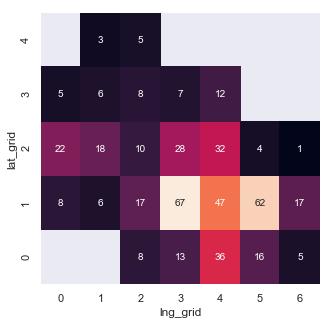

In [31]:

# now we can visualize our data for 19 May 2017 on the map.
dt_geogrid = singleday_dt_full.groupby(['lat_grid','lng_grid']).agg({'events': np.sum}).reset_index()
dt_geoheatmap = dt_geogrid.pivot(index='lat_grid', columns='lng_grid', values='events')
# generate heatmap
fig, ax = plt.subplots(figsize=(5,5))  
ax = sns.heatmap(dt_geoheatmap,annot=True,fmt=".0f",cbar=False)
ax.invert_yaxis()
plt.show()
fig = ax.get_figure()
fig.savefig("6.png")


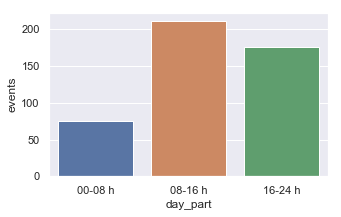

In [32]:
data_timeevents = singleday_dt_full.groupby(['day_part']).agg({'events': np.sum}).reset_index()
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.barplot(x="day_part", y="events", data=data_timeevents)
ax.axes.set_xticklabels(["00-08 h","08-16 h","16-24 h"])
pass